# NMME Niño 3.4

In [1]:
import numpy as np
import xarray as xr

import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
nmme_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/'
n34_url = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'

In [3]:
model_list = ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2']

## Functions

In [4]:
# For the IRI DL 'months since' unit
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [5]:
# correlation as function of start month
def ac_by_start(x, y):
    xa = x.groupby('S.month') - x.groupby('S.month').mean('S') 
    ya = y.groupby('S.month') - y.groupby('S.month').mean('S') 
    c = (xa*ya).groupby('S.month').mean('S')/xa.groupby('S.month').std('S')/ya.groupby('S.month').std('S')
    c.attrs['long_name'] = 'correlation'
    c.month.attrs['long_name'] = 'start month'
    return c

In [6]:
# MSE skill score as a function of start month
def msess_by_start(f, o):
    # assumes:
    # 1. f and o are anomalies (the mean is not removed here)
    # 2. the reference forecast is zero anomaly
    # Note: use mean instead of sum to get the desired nan behavior (nan if all values missing. e.g., models with shorter forecasts)
    msess = 1.0 - ((f - o)**2).groupby('S.month').mean('S')/(o**2).groupby('S.month').mean('S')
    msess.attrs['long_name'] = 'MSESS'
    msess.month.attrs['long_name'] = 'start month'
    return msess

# Read data

## Obserations (ERSSTv5)

743.5


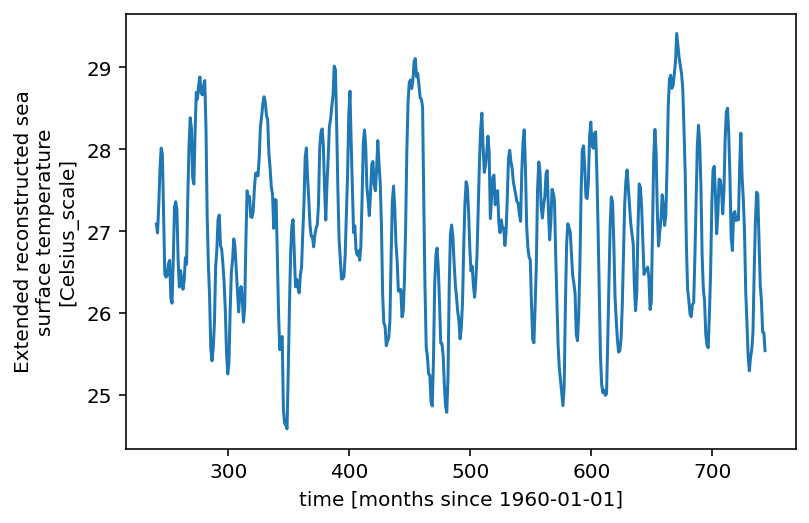

In [7]:
#Observations do not have to match the forecasts

# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
time_str = 'T/(Jan%201980)/last/RANGE/'
obs_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + n34_url + 'zlev/removeGRID/' + 'dods'

obs_ds = xr.open_dataset(obs_url, decode_times=False)

# BECAUSE the forecasts go beyond the obs pad with 14 nan
extra_T = np.arange(obs_ds.T[0], obs_ds.T[-1] + 14)
obs_ds_padded = obs_ds.reindex({'T': extra_T})
obs = obs_ds_padded.sst
print(obs_ds.T[-1].values)
obs.plot();

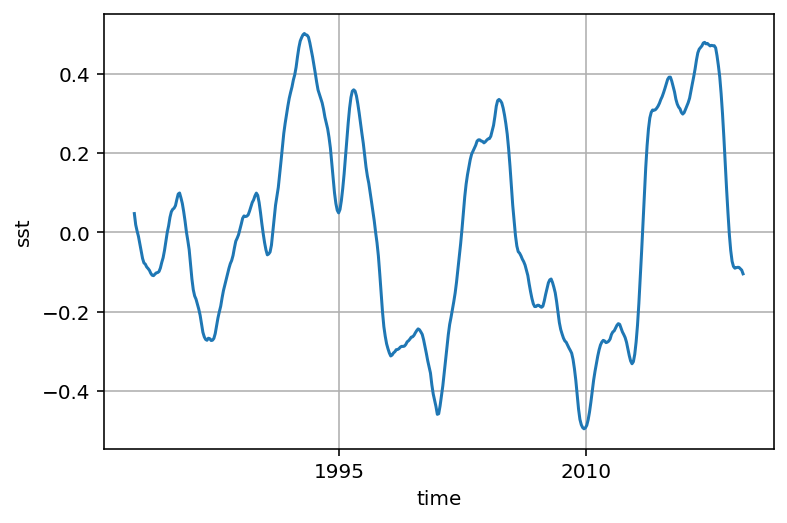

In [8]:
obsa_ds = decode_cf(obs_ds, 'T')
obsa = obsa_ds.sst
obsa = obsa.groupby('T.month') - obsa.groupby('T.month').mean('T')
obsa.rolling(T=5*12, center=True).mean().plot()
plt.grid()

# Six active NMME models

In [9]:
# We will make a list of data sets and then merge them
ds_list = []

# mask for the 1991-2020 climatology
import cftime 
clim_start = cftime.Datetime360Day(1991, 1, 16, 0, 0, 0, 0)
clim_end = cftime.Datetime360Day(2020, 12, 16, 0, 0, 0, 0)

## 0. CanCM4i (OLD)

2021-11-01 00:00:00


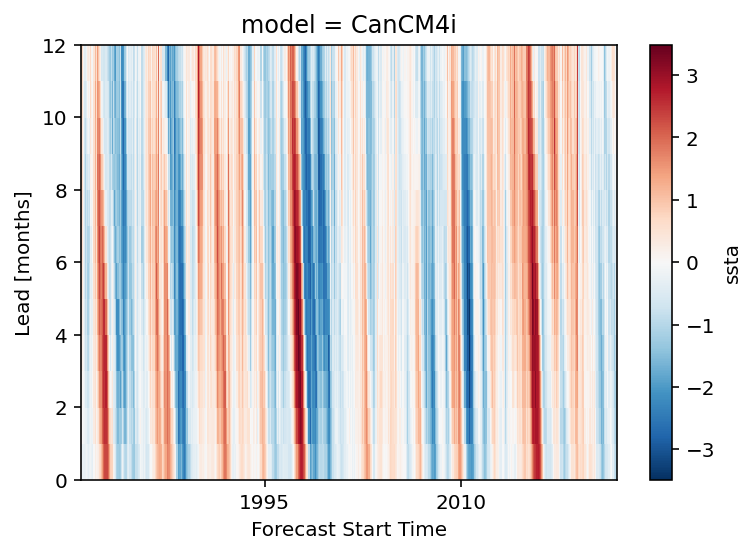

In [10]:
#CanCM4i
model = 'CanCM4i'
# hindcast
h_url = nmme_url + '.CanCM4i/.HINDCAST/.MONTHLY/.sst/' + n34_url + 'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)

#realtime
f_url = nmme_url + '.CanCM4i/.FORECAST/.MONTHLY/.sst/S/(Jan%202019)/last/RANGE/' + n34_url + 'dods'
f_ds = xr.open_dataset(f_url, decode_times=False)

ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds['sst'] = ds.sst - 273.15
T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# climo period by start
# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [11]:
# ds_list.append(ds)

## 1. GEM-NEMO (OLD)

2021-11-01 00:00:00


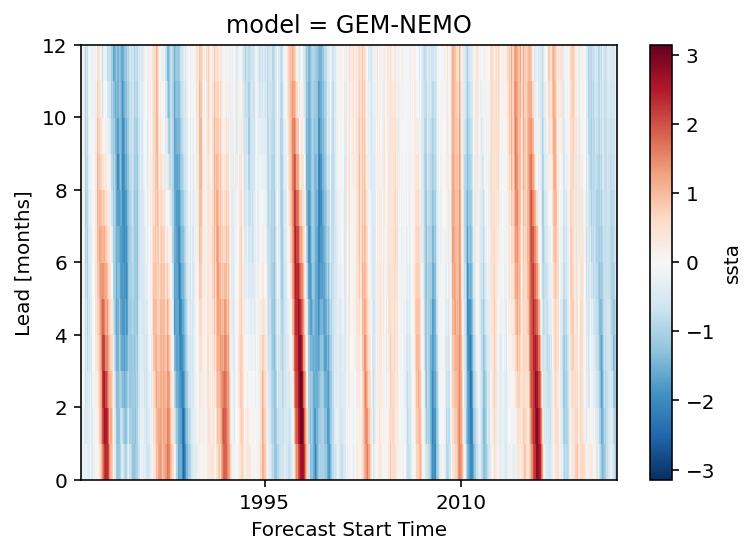

In [12]:
#GEM-NEMO
model = 'GEM-NEMO'
h_url = nmme_url + '.GEM-NEMO/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.GEM-NEMO/.FORECAST/.MONTHLY/.sst/S/(Jan%202019)/last/RANGE/' + n34_url +'dods'
#f_url = nmme_url + '.GEM-NEMO/.FORECAST/.MONTHLY/.sst/' + n34_url +'dods'

h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds['sst'] = ds.sst - 273.15

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [13]:
# ds_list.append(ds)

## 0. CanSIPS-IC3 = GEM-NEMO + CanCM4i

2022-01-01 00:00:00


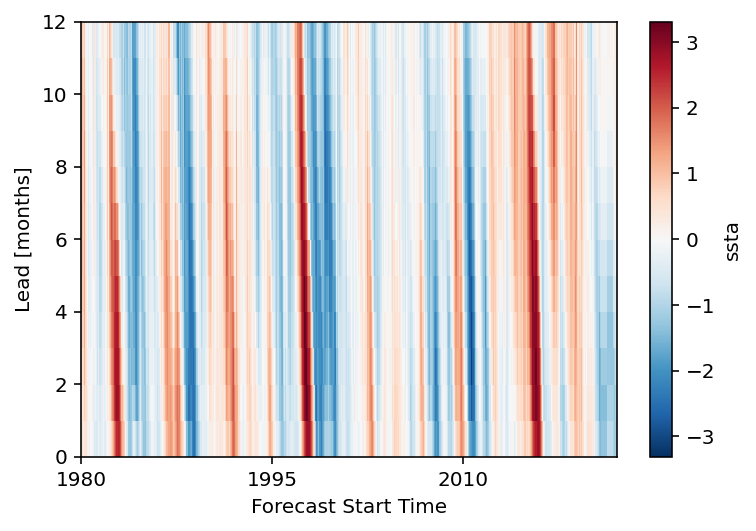

In [14]:
#GEM-NEMO
# E. Becker "The first 10 ensemble members are GEM-NEMO and 11-20 are cancm4i."
model = 'CanSIPS-IC3'
h_url = nmme_url + '.CanSIPS-IC3/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.CanSIPS-IC3/.FORECAST/.MONTHLY/.sst/S/(Jan%202020)/last/RANGE/' + n34_url +'dods'
#f_url = nmme_url + '.GEM-NEMO/.FORECAST/.MONTHLY/.sst/' + n34_url +'dods'

h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

# Don't add the model now b/c can't change later
#ds.coords['model'] = model
#ds = ds.expand_dims('model')

ds['sst'] = ds.sst - 273.15

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [15]:
# keep copy for later
ds_tmp = ds.copy()

### a. GEM-NEMO

2022-01-01 00:00:00


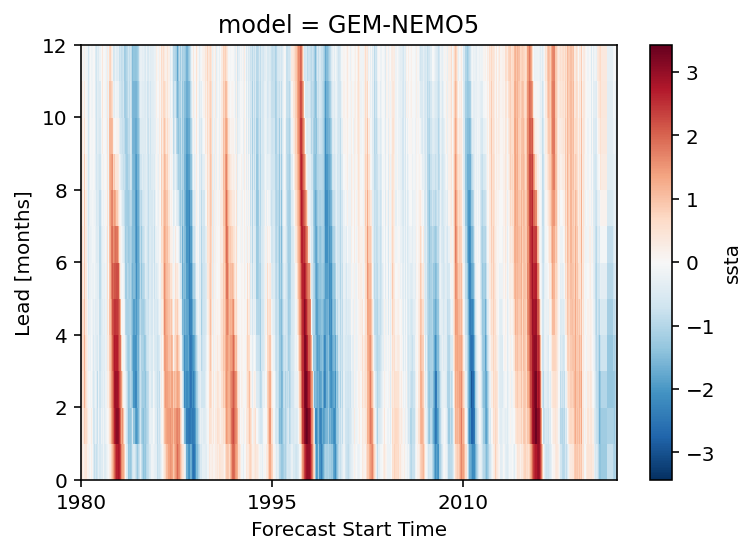

In [16]:
ds = ds_tmp.sel(M=slice(1, 10)).copy()
model = 'GEM-NEMO5'
ds.coords['model'] = model
ds = ds.expand_dims('model')

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [17]:
ds_list.append(ds)

### b. CanCM4i

2022-01-01 00:00:00


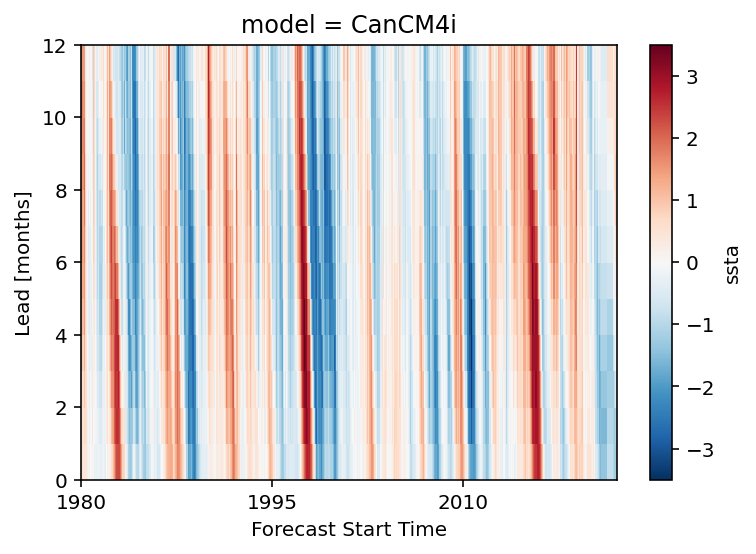

In [18]:
ds = ds_tmp.sel(M=slice(11, 20)).copy()
model = 'CanCM4i'
ds.coords['model'] = model
ds = ds.expand_dims('model')

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [19]:
ds.assign_coords(M=(ds.M - 10))

<xarray.Dataset>
Dimensions:  (L: 12, M: 10, S: 496, model: 1)
Coordinates:
  * S        (S) object 1980-01-01 00:00:00 ... 2022-01-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
    month    (S) int64 1 2 3 4 5 6 7 8 9 10 11 ... 6 7 8 9 10 11 12 10 11 12 1
  * model    (model) <U7 'CanCM4i'
Data variables:
    sst      (model, S, M, L) float64 27.3 27.22 27.13 ... 26.58 26.68 26.81
    Lmax     (model) int64 12
    Mmax     (model) int64 20
    obs      (model, L, S) float64 27.09 26.98 27.32 27.76 ... nan nan nan nan
    target   (model, L, S) object 1980-01-16 00:00:00 ... 2022-12-16 00:00:00
    ssta     (model, S, M, L) float64 0.7534 0.8632 0.787 ... 1.183 1.042 1.067
Attributes:
    Conventions:  IRIDL

In [20]:
ds_list.append(ds)

## 2. GFDL-SPEAR

2022-01-01 00:00:00


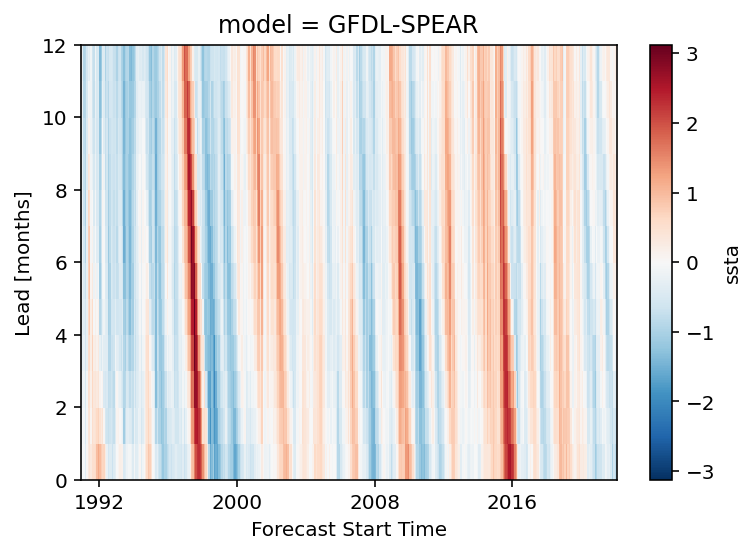

In [21]:
#GFDL-SPEAR
model = 'GFDL-SPEAR'
h_url = nmme_url + '.GFDL-SPEAR/.HINDCAST/.MONTHLY/.sst/' + n34_url + 'dods'
f_url = nmme_url + '.GFDL-SPEAR/.FORECAST/.MONTHLY/.sst/S/(Jan%202021)/last/RANGE/' + n34_url + '7/pop/dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# use number of lead in hindcast
# should make lead a function of start
ds['Lmax'] = len(h_ds.L)
ds['Mmax'] = len(h_ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [22]:
ds_list.append(ds)

## 3. COLA-RSMAS-CCSM4

2022-01-01 00:00:00


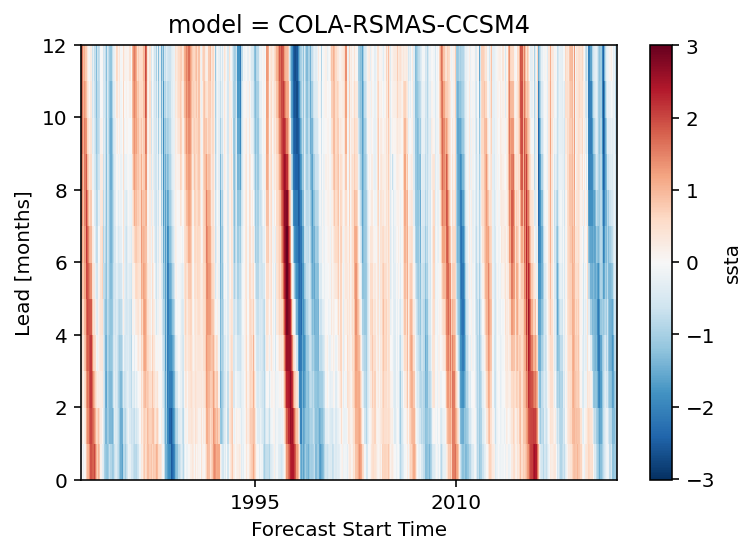

In [23]:
#COLA-RSMAS-CCSM4
model = 'COLA-RSMAS-CCSM4'
url = nmme_url + '.COLA-RSMAS-CCSM4/.MONTHLY/.sst/' + n34_url + '8/pop/dods'
ds = xr.open_dataset(url, decode_times=False)

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# two climatologies by start
f1 = ds.sst.sel(S=slice('1982-01-01', '1998-12-01'))
ssta1 = f1.groupby('S.month') - f1.groupby('S.month').mean(('S', 'M'))

f2 = ds.sst.sel(S=slice('1999-01-01', None))
ssta2 = f2.groupby('S.month') - f2.sel(S=slice('1999-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta = xr.concat([ssta1, ssta2], dim='S')

ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [24]:
ds_list.append(ds)

## 4. NASA-GEOSS2S

2022-01-01 00:00:00


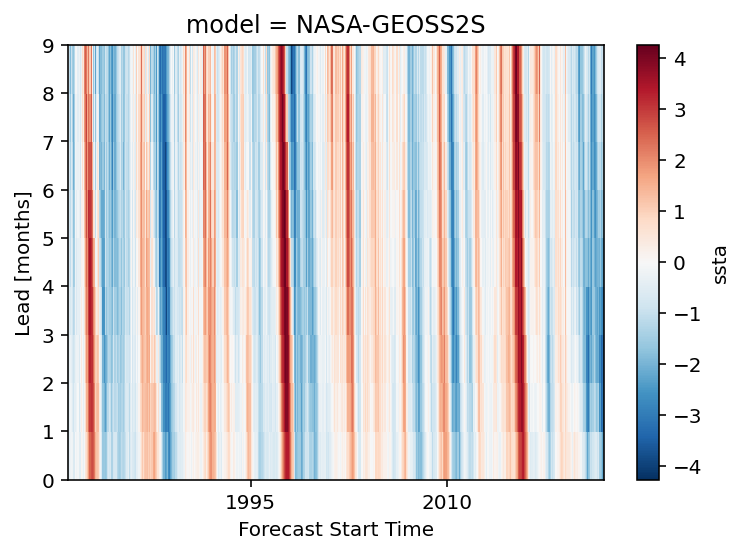

In [25]:
#NASA-GEOSS2S
model = 'NASA-GEOSS2S'

h_url = nmme_url + '.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.NASA-GEOSS2S/.FORECAST/.MONTHLY/.sst/' + n34_url +'9/pop/dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# use number of leads in hindcast
# should make lead a function of start?
ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(h_ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'
ds["obs"] = (("L", "S"), obs.sel(T=T))

ds = decode_cf(ds, 'S')

# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [26]:
ds_list.append(ds)

## 5. NCEP-CFSv2

CFSv2

Compute anaomlies by removing 2 forecast climatologies. One for 1982-1998 and one for 1999-2020.

2022-01-01 00:00:00


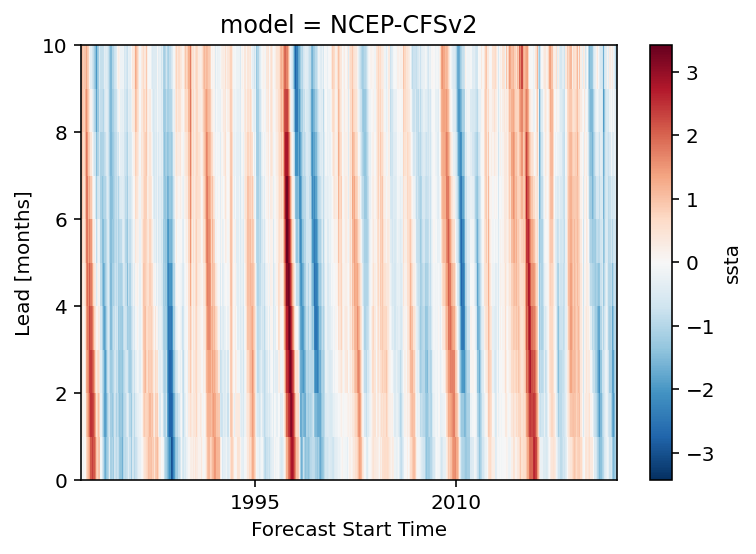

In [27]:
#NCEP-CFSv2
model = 'NCEP-CFSv2'
h_url = nmme_url + '.NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.sst/' + n34_url +'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)
ds['Mmax'] = 24

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

f1 = ds.sst.sel(S=slice('1982-01-01', '1998-12-01'))
ssta1 = f1.groupby('S.month') - f1.groupby('S.month').mean(('S', 'M'))
f2 = ds.sst.sel(S=slice('1999-01-01', None))
ssta2 = f2.groupby('S.month') - f2.sel(S=slice('1999-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta = xr.concat([ssta1, ssta2], dim='S')

ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [28]:
ds_list.append(ds)

In [29]:
len(ds_list)

6

## Multimodel ensemble

In [30]:
ds = xr.merge(ds_list)

o = ds.obs
ds['obsa'] = o.groupby("S.month") - o.sel(S=slice('1991-01-01', '2020-12-01')).groupby("S.month").mean("S")
ds


<xarray.Dataset>
Dimensions:  (L: 12, M: 30, S: 505, model: 6)
Coordinates:
  * L        (L) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * M        (M) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 26.0 27.0 28.0 29.0 30.0
  * S        (S) object 1980-01-01 00:00:00 ... 2022-01-01 00:00:00
  * model    (model) <U16 'COLA-RSMAS-CCSM4' 'CanCM4i' ... 'NCEP-CFSv2'
    month    (S) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0 1.0
Data variables:
    sst      (model, S, M, L) float64 nan nan nan nan nan ... nan nan nan nan
    Lmax     (model) float64 12.0 12.0 12.0 12.0 9.0 10.0
    Mmax     (model) float64 10.0 20.0 20.0 15.0 4.0 24.0
    obs      (model, L, S) float64 nan nan nan nan nan ... nan nan nan nan nan
    target   (model, L, S) object nan nan ... 2022-12-16 00:00:00
    ssta     (model, S, M, L) float64 nan nan nan nan nan ... nan nan nan nan
    obsa     (model, L, S) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  IRIDL

# Save local copy (if you want, or skip)

In [31]:
ds_saved = ds.copy()

import pickle
#save a copy locally
with open('n34_nmme_saved_on_disk', 'wb') as f:
    pickle.dump(ds, f, pickle.HIGHEST_PROTOCOL)

In [32]:
import pickle
#read a copy 
with open('n34_nmme_saved_on_disk', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ds = pickle.load(f)

# Plot data

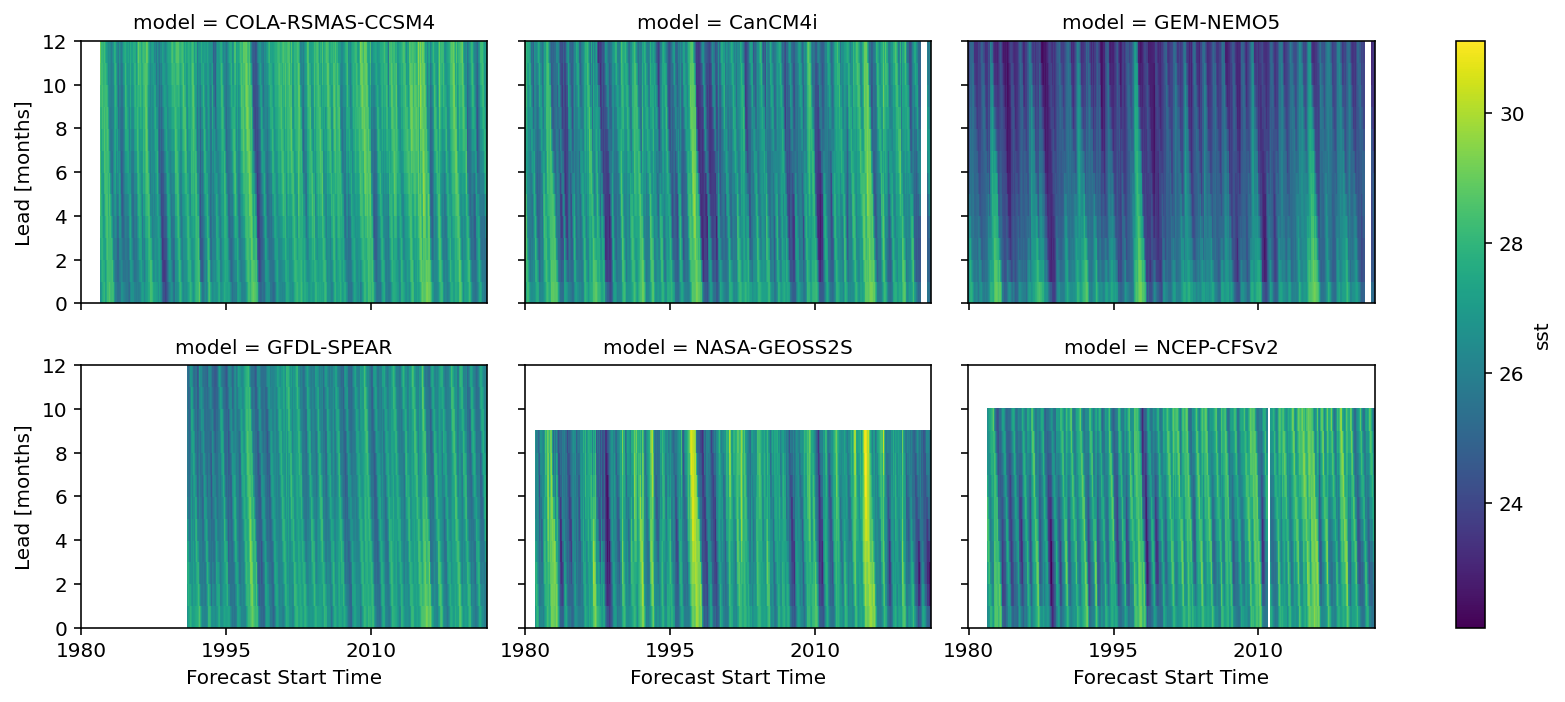

In [33]:
#Ensemble mean (total)
ds.sst.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

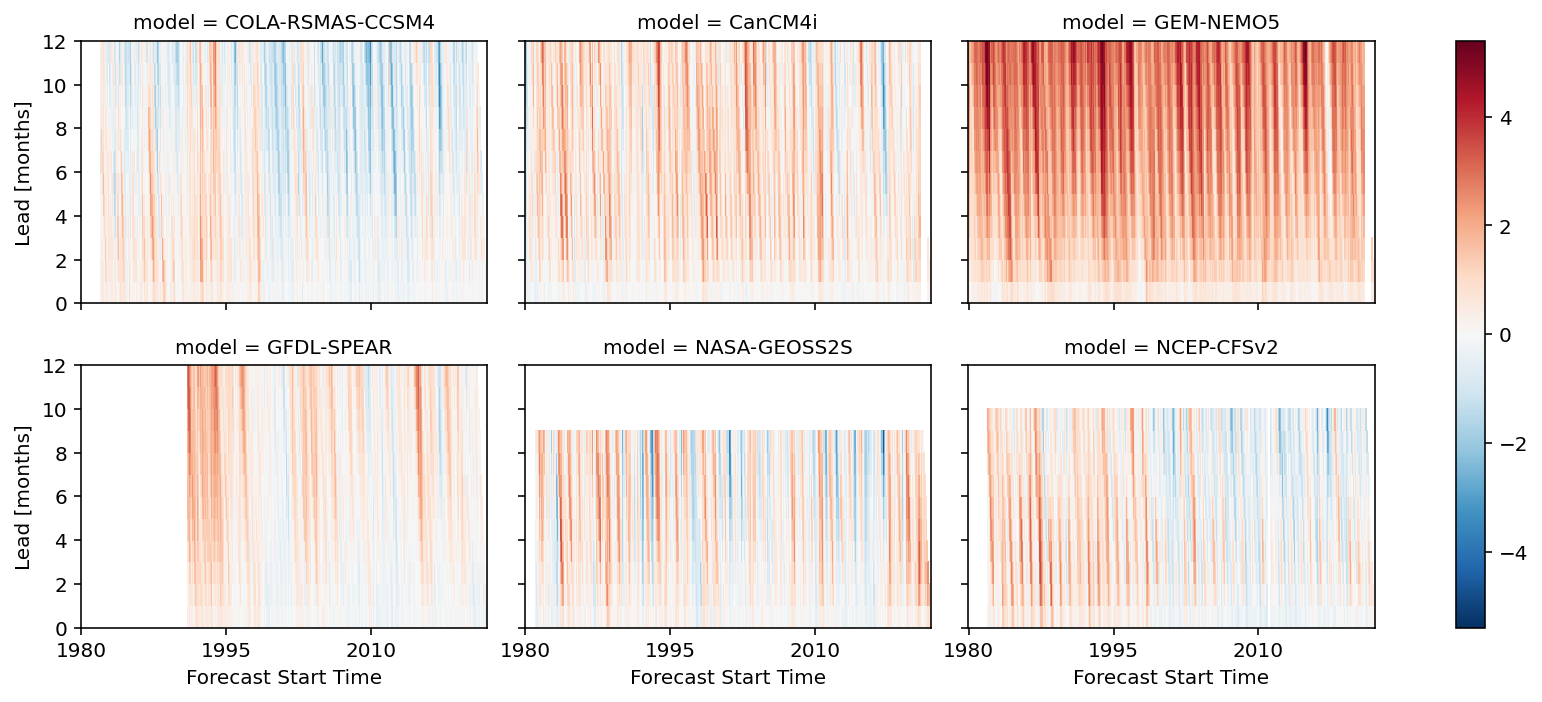

In [34]:
#Ensemble mean error (total)
(ds.obs - ds.sst.mean('M')).plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

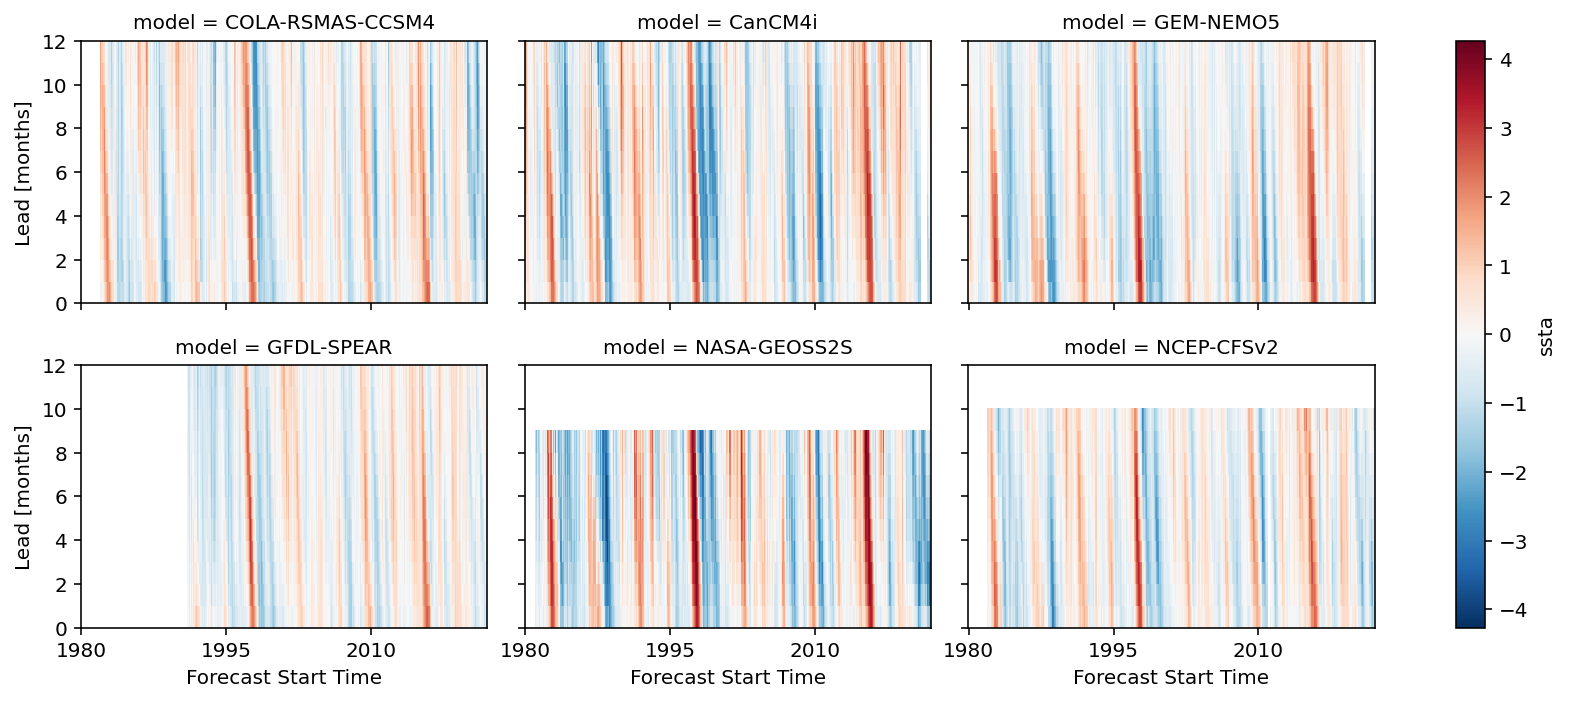

In [35]:
#Ensemble mean anomalies
ds.ssta.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

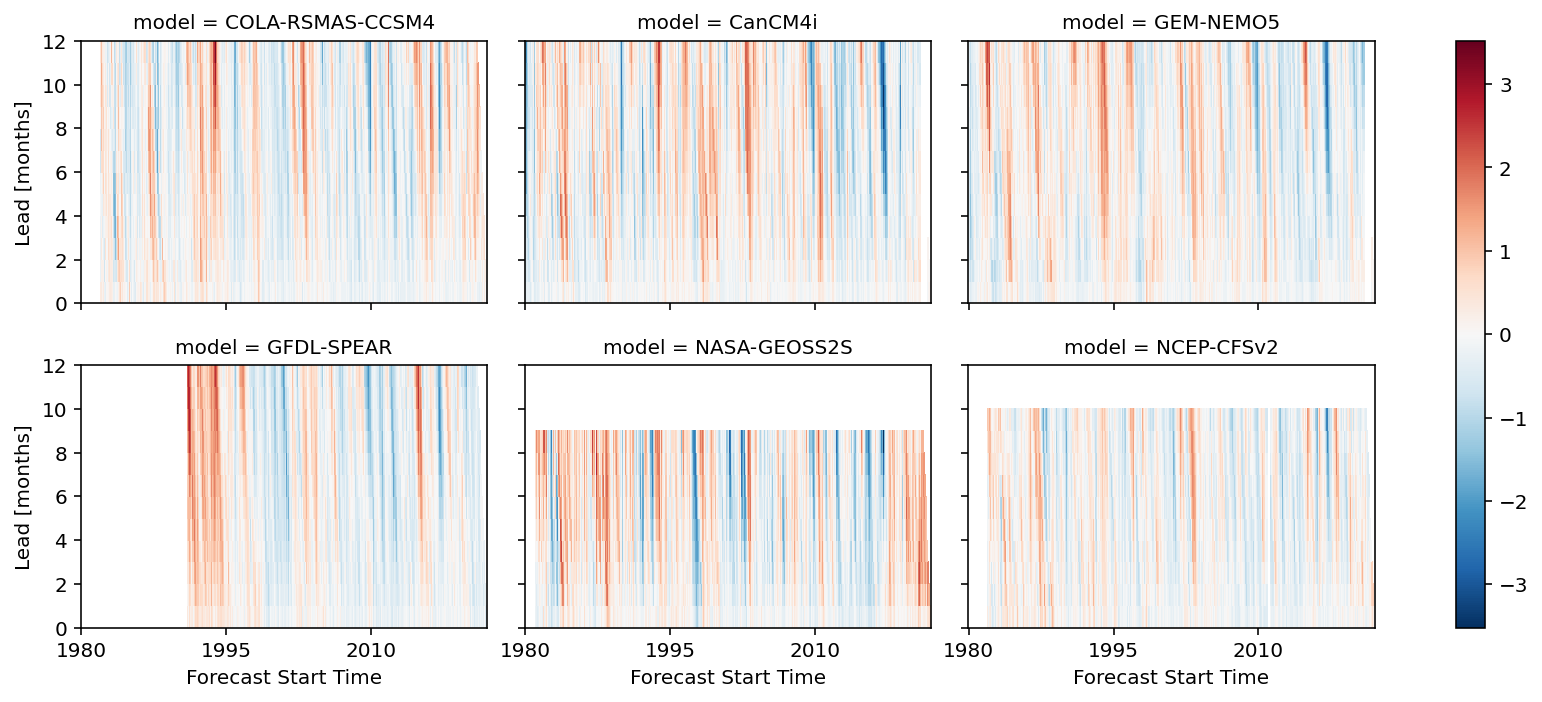

In [36]:
#Ensemble mean anomaly error
(ds.obsa - ds.ssta.mean('M')).plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

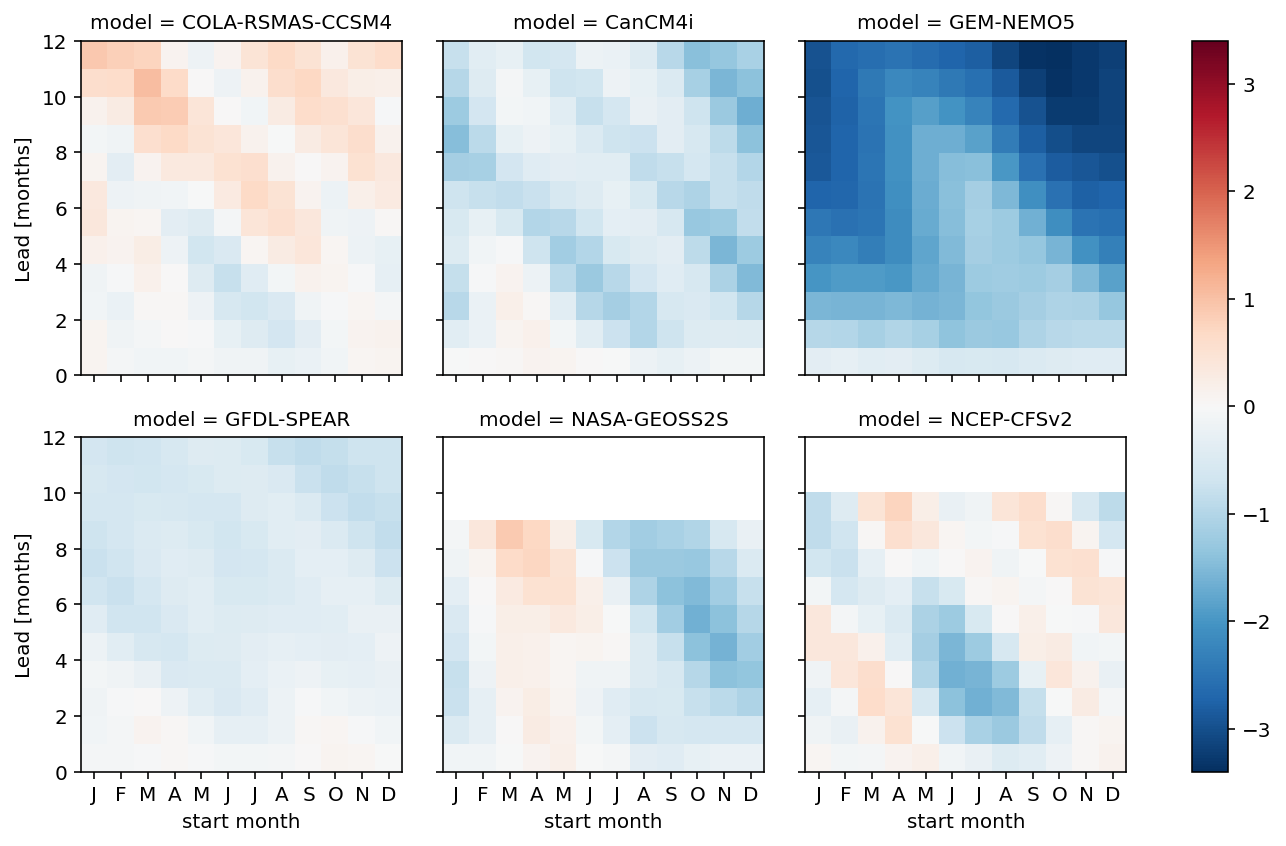

In [37]:
# Bias
bias = (ds.sst - ds.obs).groupby('S.month').mean(('M', 'S'))
bias.month.attrs['long_name'] = 'start month'
bias.plot(col='model', col_wrap = 3, x='month')
plt.xticks(ds.L + 0.5, labels=m_str)
plt.show()

# Skill by lead

## 1. Correlation

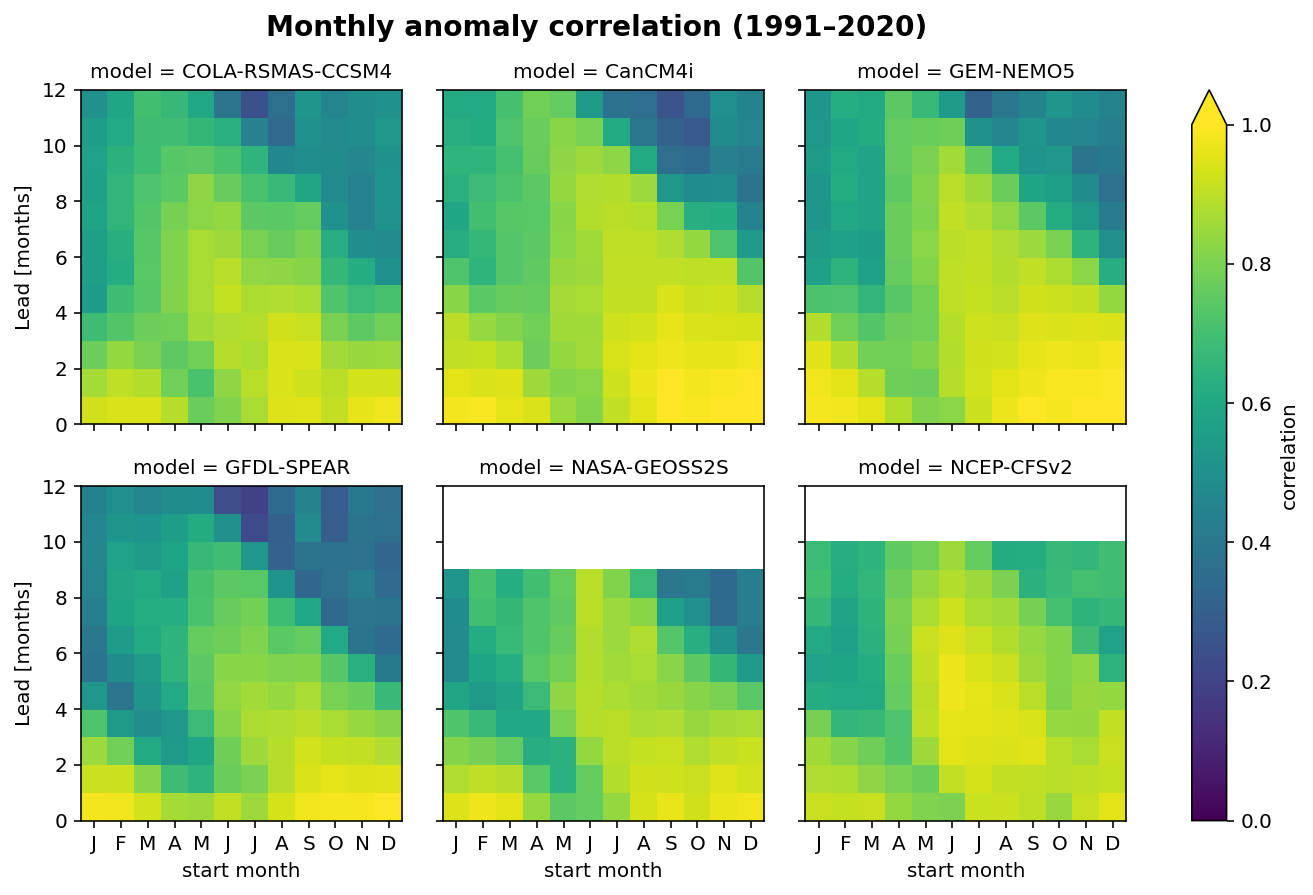

In [38]:
ac1 = ac_by_start(ds.ssta.mean('M'), ds.obsa.sel(S=slice('1991-01-01', '2020-12-01')))
#ac = ac_by_start(ds.ssta.mean('M'), ds.obsa)
fg = ac1.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (1991–2020)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

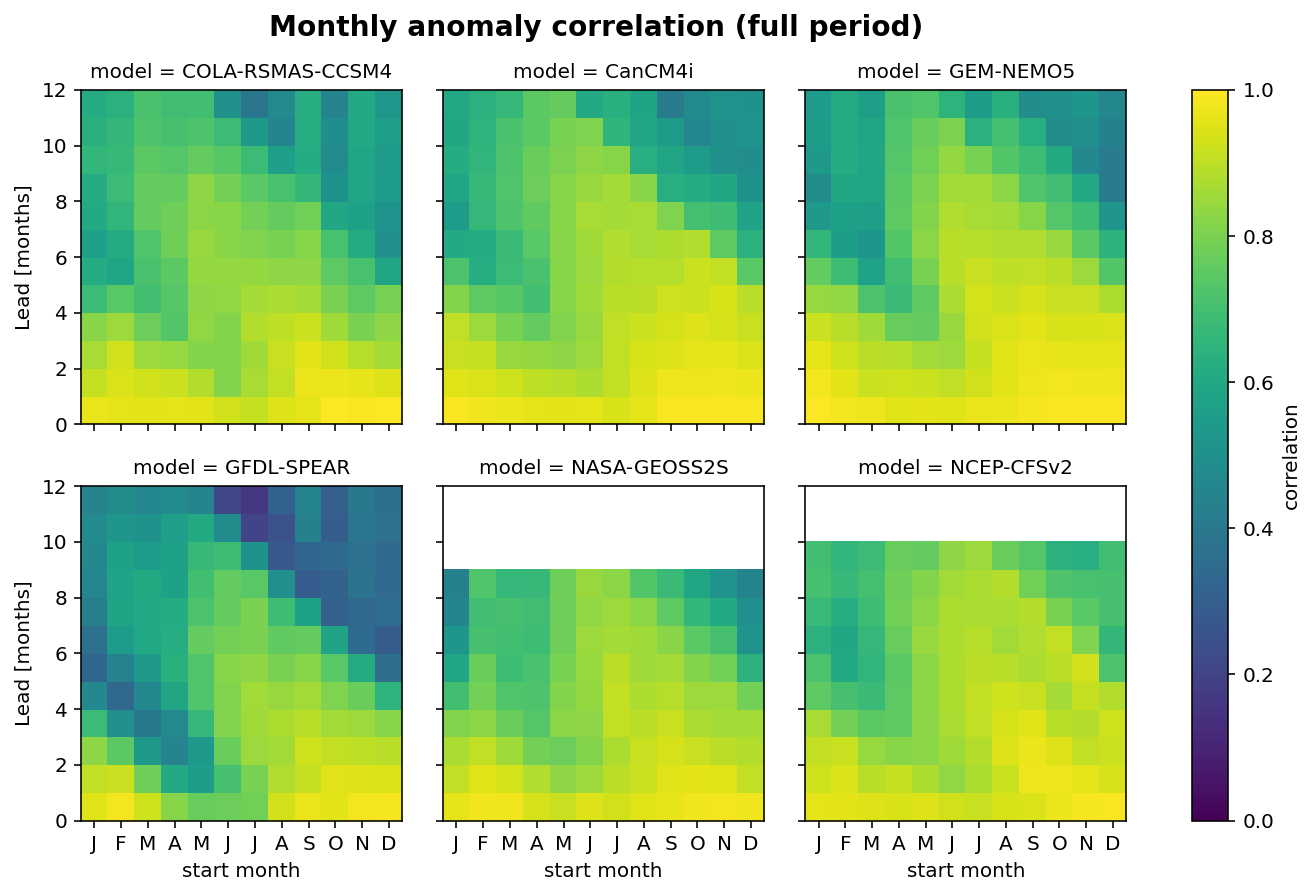

In [39]:
#ac = ac_by_start(ds.ssta.mean('M').rolling(L=3).mean(), ds.obsa.rolling(L=3).mean())
ac = ac_by_start(ds.ssta.mean('M'), ds.obsa)
fg = ac.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1)
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (full period)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

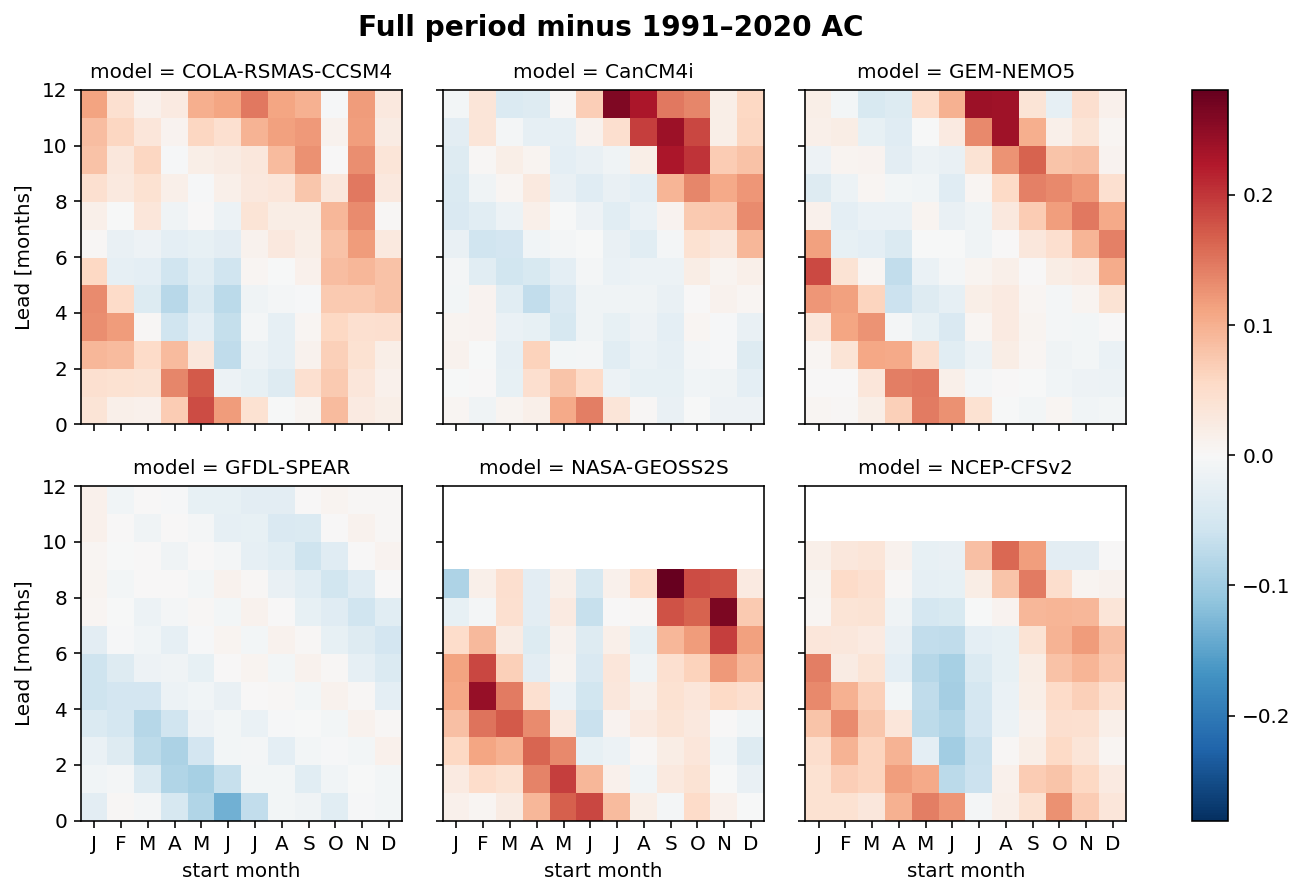

In [40]:
fg = (ac - ac1).plot(col='model', col_wrap = 3, x='month');
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Full period minus 1991–2020 AC', x=0.43, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")

In [41]:
ac_target = ac.copy()
ac_target.month.attrs['long_name'] = 'target month'
for ii in range(0, 12):
    #ac_target[:, :, ii] = np.roll(ac[:, :, ii].values, ii)
    ac_target.loc[dict(L=(ii+0.5))] = ac_target.loc[dict(L=(ii+0.5))].roll(month=ii, roll_coords=False)

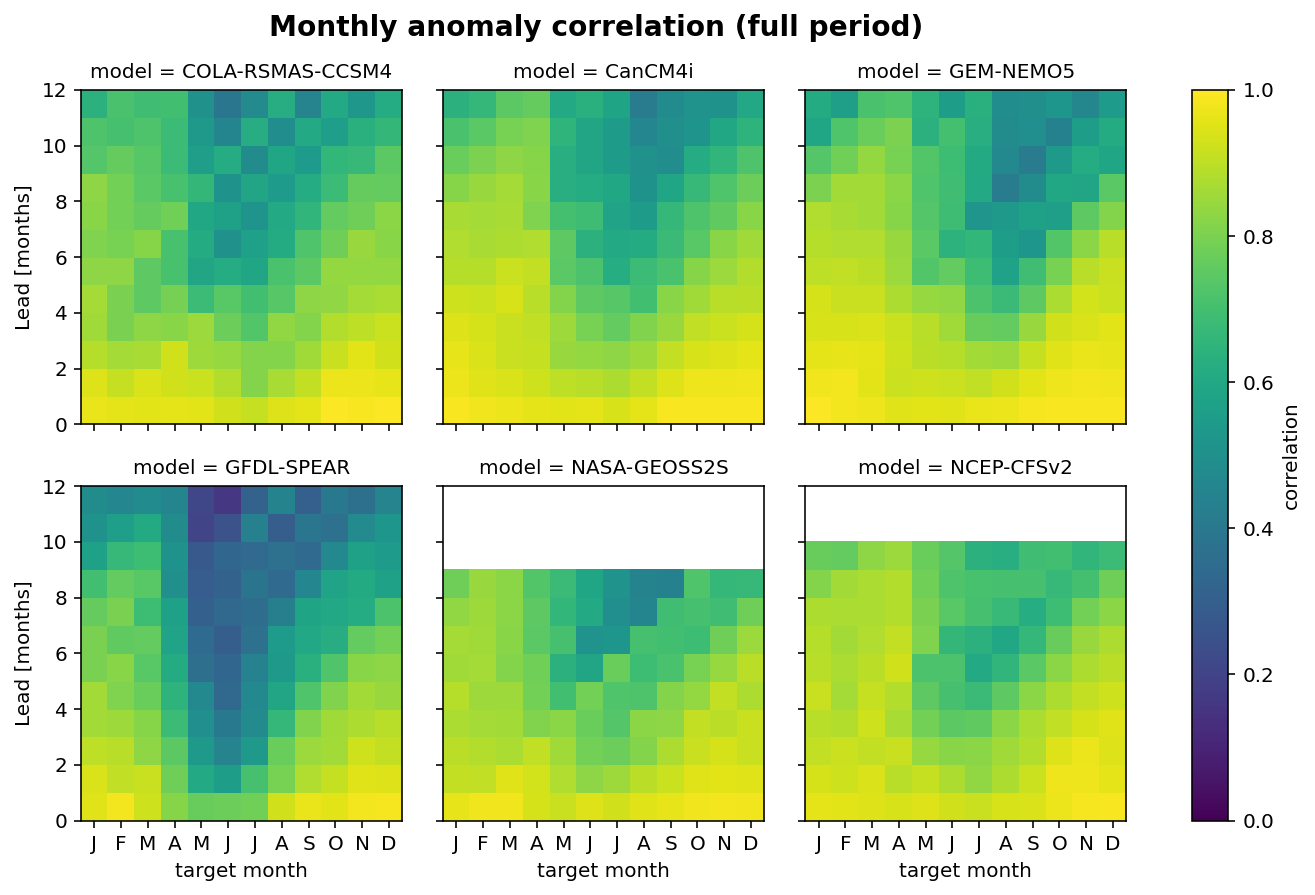

In [42]:
fg = ac_target.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (full period)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [43]:
np.nanmean(ac_target.sel(model='NCEP-CFSv2').values[:, [0, 1, 2, 3, 4, 11]])**2

0.7962674670391198

## 2. MSESS

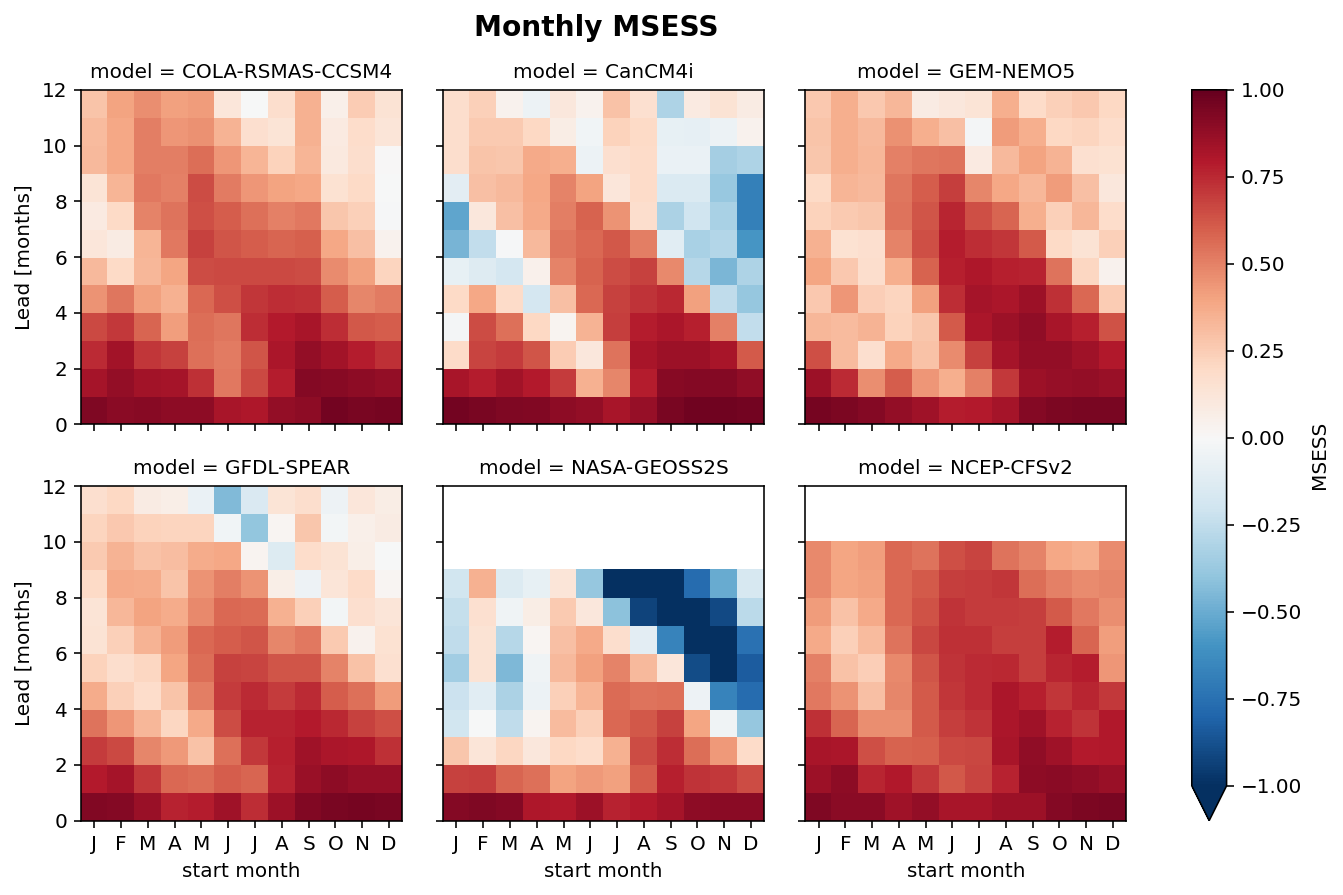

In [44]:
msess = msess_by_start(ds.ssta.mean('M'), ds.obsa)
fg = msess.plot(col='model', col_wrap = 3, x='month', vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly MSESS', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [45]:
msess_target = msess.copy()
msess_target.month.attrs['long_name'] = 'target month'
for ii in range(0, 12):
    msess_target.loc[dict(L=(ii+0.5))] = msess_target.loc[dict(L=(ii+0.5))].roll(month=ii, roll_coords=False)

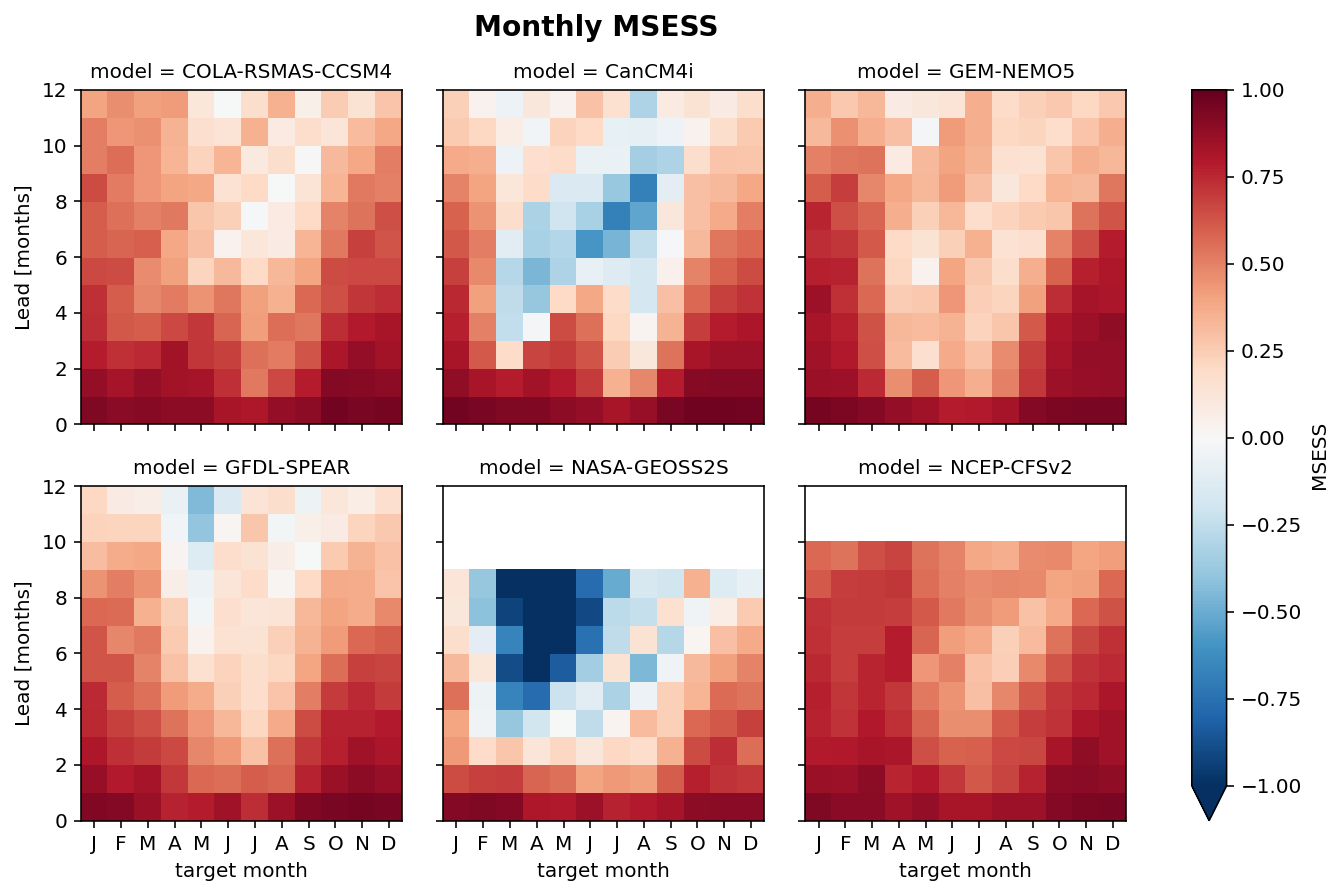

In [46]:
fg = msess_target.plot(col='model', col_wrap = 3, x='month', vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly MSESS', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

# Plume

## Most recent forecast 

In [47]:
# ds.sst.loc[dict(model='NASA-GEOSS2S', S='2021-08-01 00:00:00',L=slice(1, None))].plot();

In [48]:
# FIX no longer needed
#ds.ssta.loc[dict(model='GFDL-SPEAR', S='2021-08-01 00:00:00', M=12, L=slice(8, None))] = np.nan

2022-01-01 00:00:00


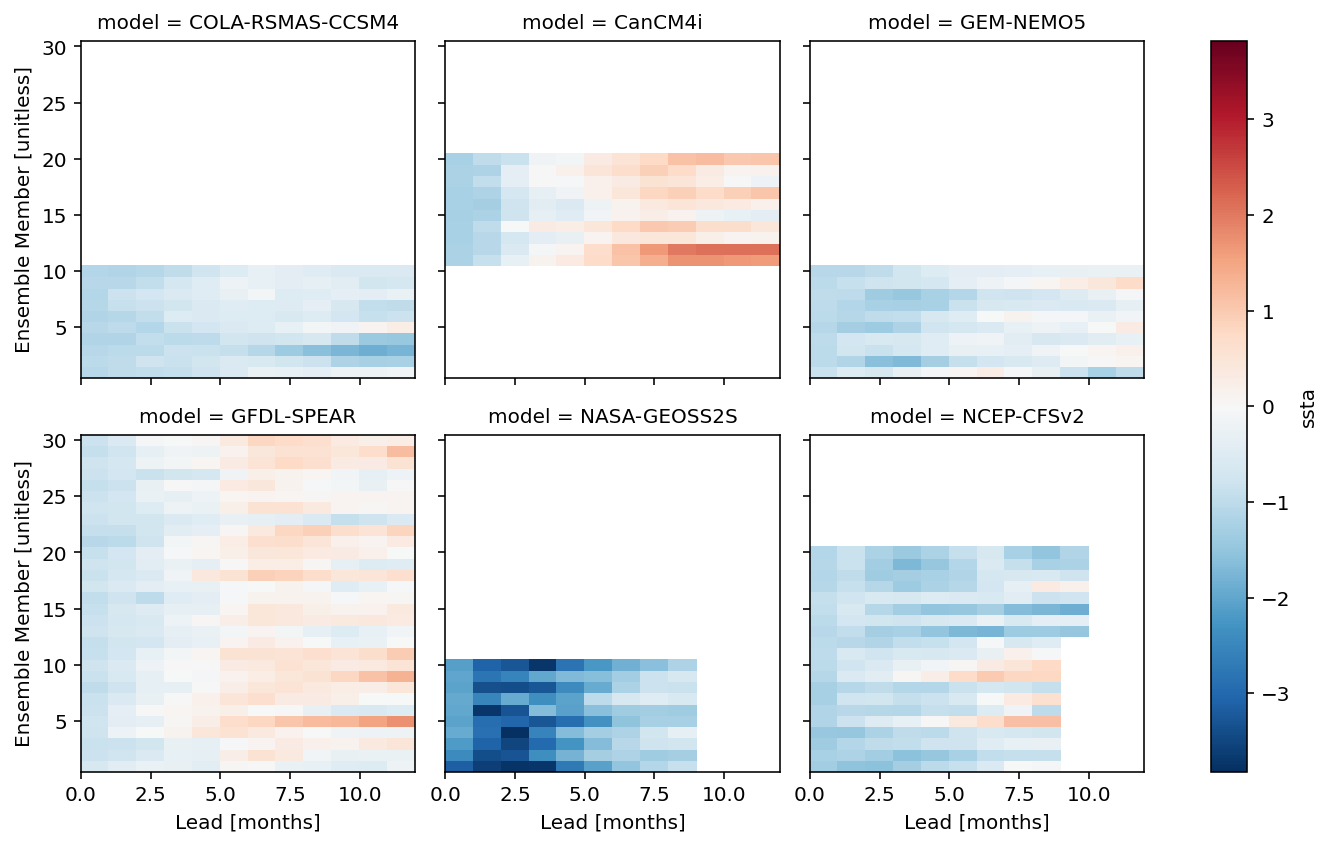

In [49]:
# Most recent forecast
fg = ds.ssta.isel(S=-1).plot(col='model', col_wrap = 3);
fig = fg.fig
fig.set_facecolor("white")
print(ds.S[-1].values)

In [50]:
#convert from cftime to regular time
start = ds.indexes['S'].to_datetimeindex()

/Users/tippett/miniconda3/envs/pangeo2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


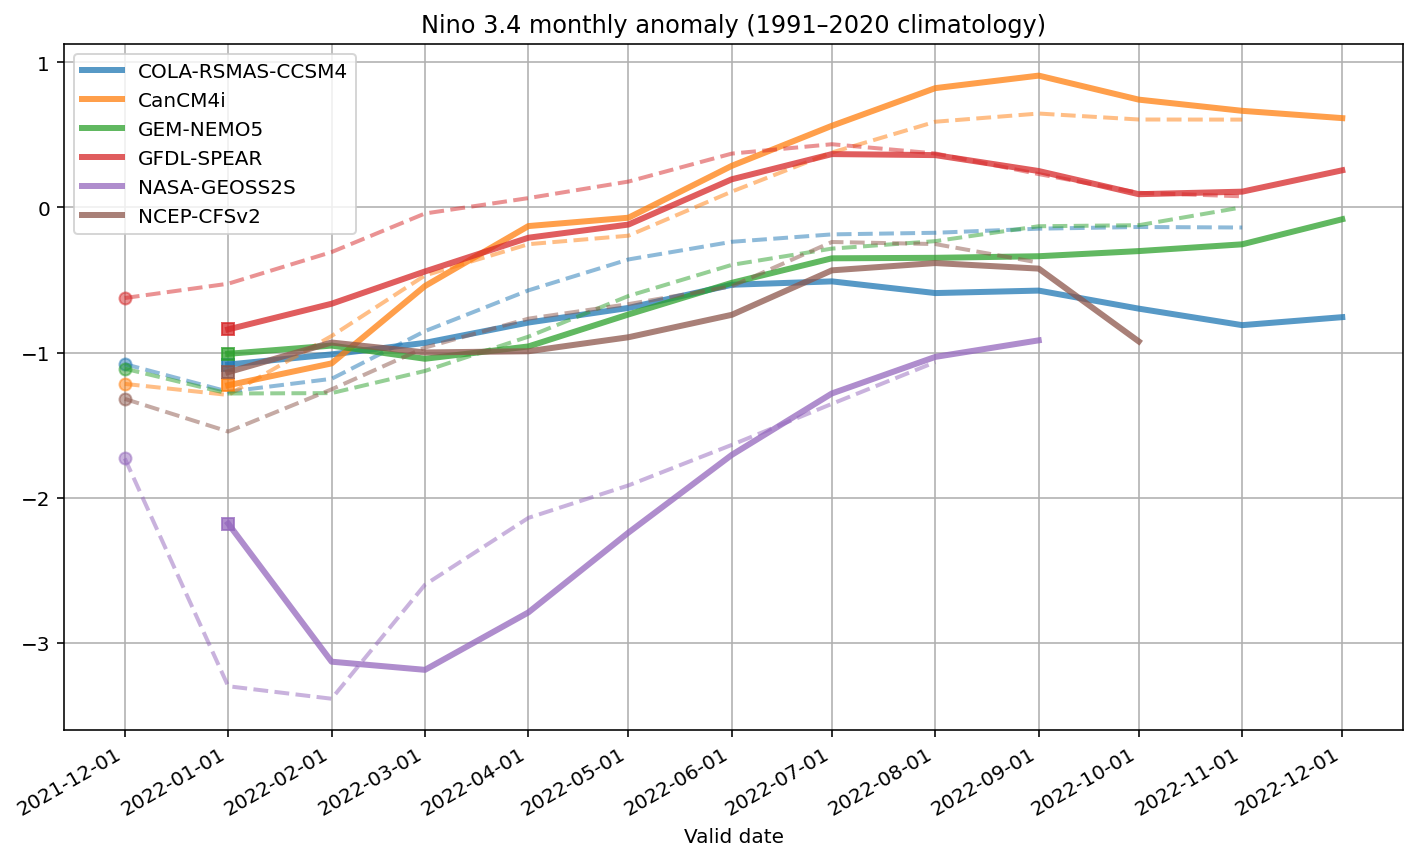

In [51]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig,ax = plt.subplots(figsize=(12, 7))
for im in avail[0]:
    #last month
    leads = pd.date_range(start[-2], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-2).mean('M').T[:, im], '--', lw=2, color=colors[im], alpha=0.5)
    ax.plot(leads[0], ds.ssta.isel(S=-2).mean('M').T[0, im], 'o', lw=2, color=colors[im], alpha=0.5)


    #this month
    leads = pd.date_range(start[-1], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T[:, im], lw=3, color=colors[im], label=ds.model.values[im], alpha=0.75)
    ax.plot(leads[0], ds.ssta.isel(S=-1).mean('M').T[0, im], 's', lw=3, color=colors[im], alpha=0.75)

ax.set_xticks(pd.date_range(start[-2], periods=13, freq="MS"))
ax.set_xlabel('Valid date')
ax.set_title('Nino 3.4 monthly anomaly (1991–2020 climatology)')
fig.autofmt_xdate()

ax.legend(ncol=1)
ax.grid()
fig.set_facecolor("white")
xlim = ax.get_xlim()

plt.savefig('recent.png')

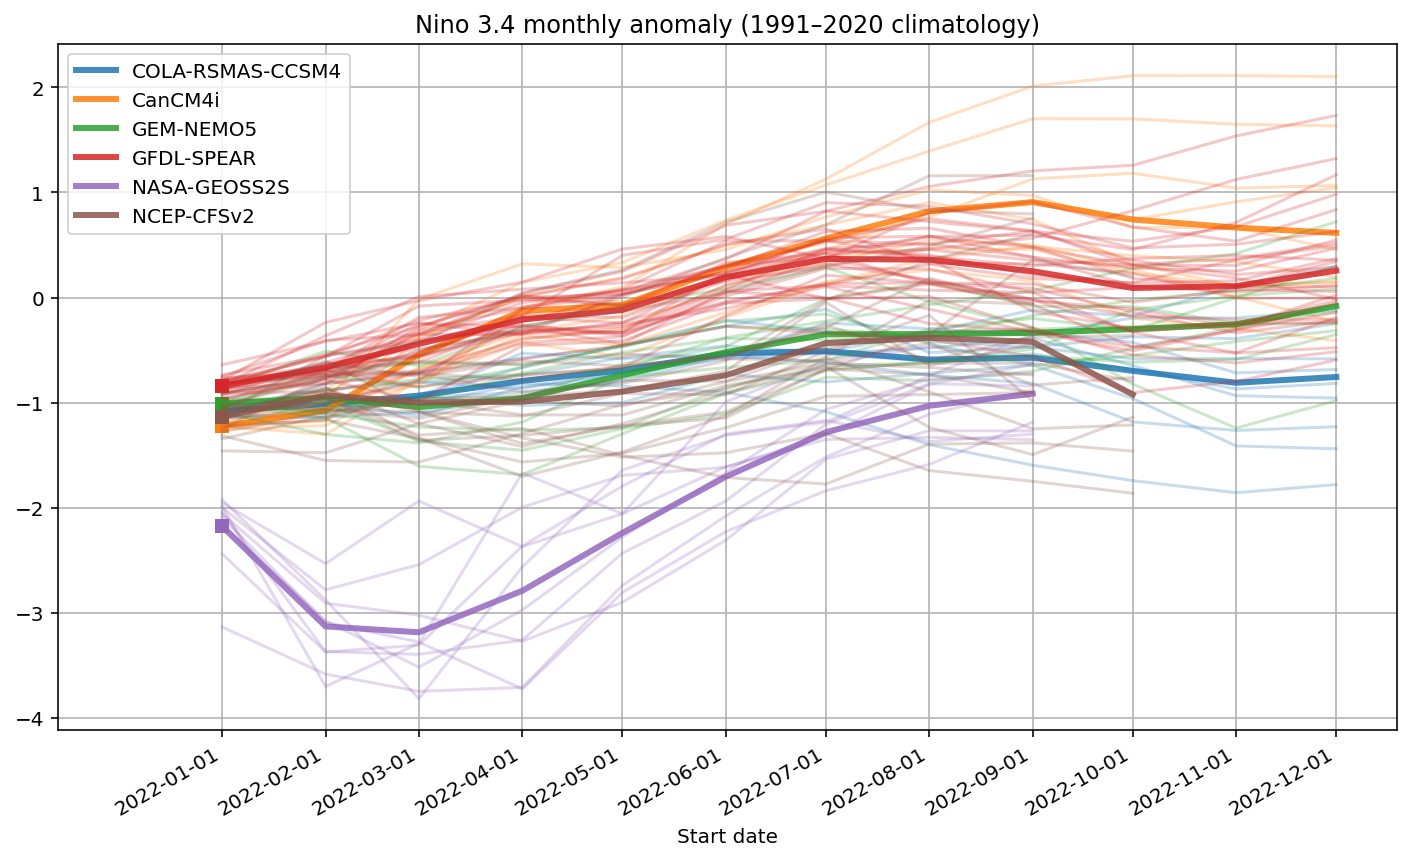

In [52]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig, ax = plt.subplots(figsize=(12, 7))
for im in avail[0]:
    
    #this month
    leads = pd.date_range(start[-1], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-1).isel(model=im).T, lw=1.5, color=colors[im], alpha=0.25)
    ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T[:, im], lw=3, color=colors[im], label=ds.model.values[im], alpha=0.85)
    ax.plot(leads[0], ds.ssta.isel(S=-1).mean('M').T[0, im], 's', lw=3, color=colors[im])

ax.set_xticks(pd.date_range(start[-1], periods=12, freq="MS"))
fig.autofmt_xdate()
ax.legend(ncol=1)
ax.grid()
ax.set_xlabel('Start date')
ax.set_title('Nino 3.4 monthly anomaly (1991–2020 climatology)')
ax.set_xlim(xlim)
ylim = ax.get_ylim()
fig.set_facecolor("white")
plt.savefig('ens.png')

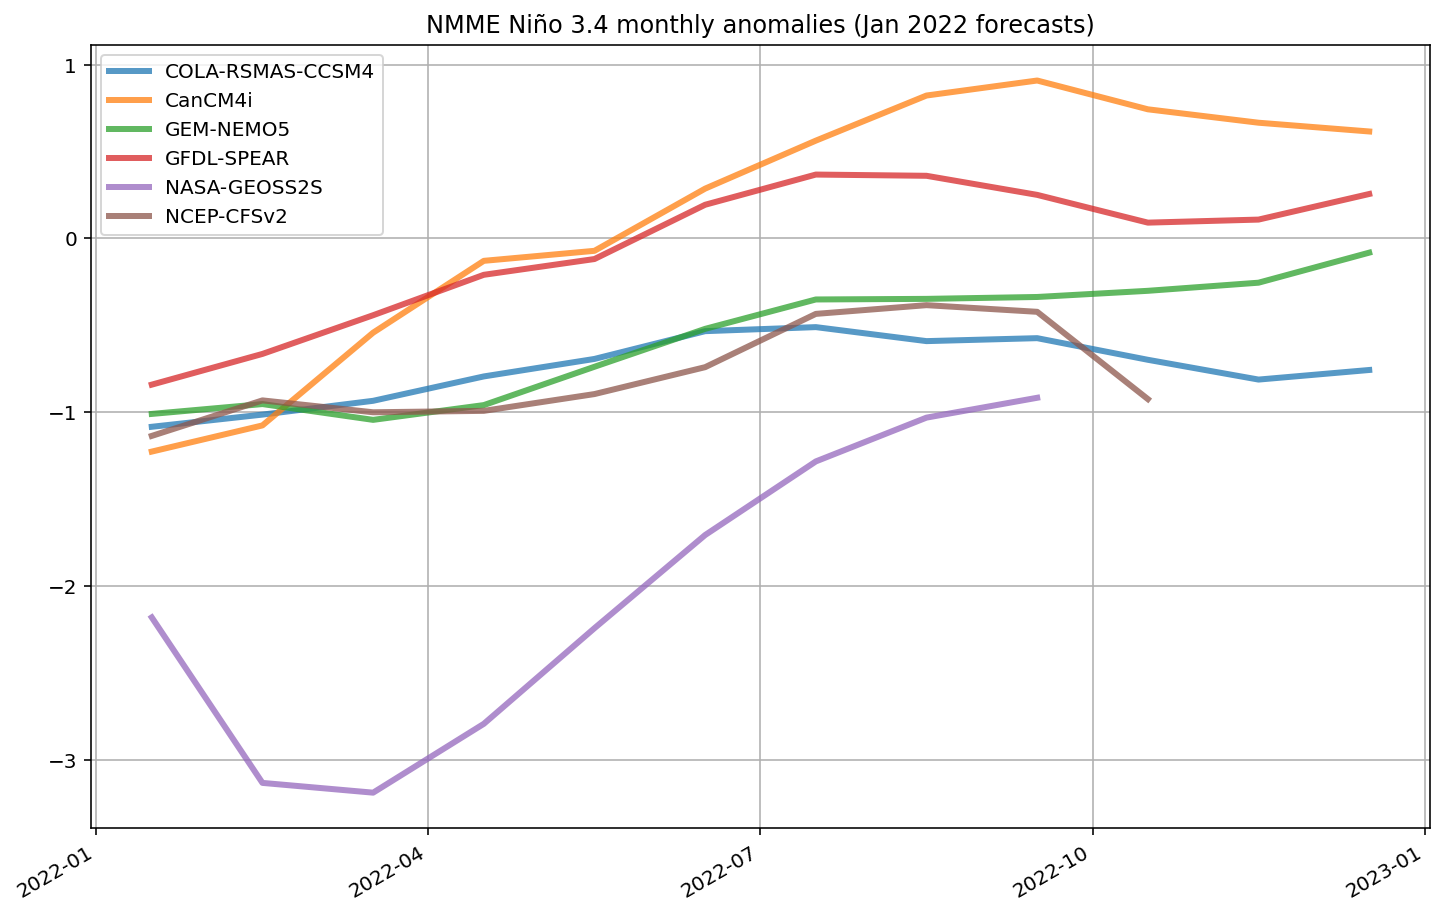

In [53]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig, ax = plt.subplots(figsize=(12, 8))
for im in avail[0]:
    target = ds.target.isel(S=-1).isel(model=im)
    forecast = ds.ssta.isel(S=-1).isel(model=im).mean('M')
    ax.plot(target, forecast, lw=3, color=colors[im], label=ds.model.values[im], alpha=0.75);

#ax.set_xticks(pd.date_range(start[-1], periods=12, freq="MS"))
fig.autofmt_xdate()

ax.legend(ncol=1)
ax.grid()
ax.set_title('NMME Niño 3.4 monthly anomalies (Jan 2022 forecasts)')
fig.set_facecolor("white")

HOW to `convert cftime._cftime.Datetime360Day` to something useful?

In [54]:
nasa = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.sst/%5BM%5D/average/L/0.5/VALUE/S/last/VALUE/Y/-30/30/RANGE/dods', decode_times=False)
nasa = decode_cf(nasa, 'S')

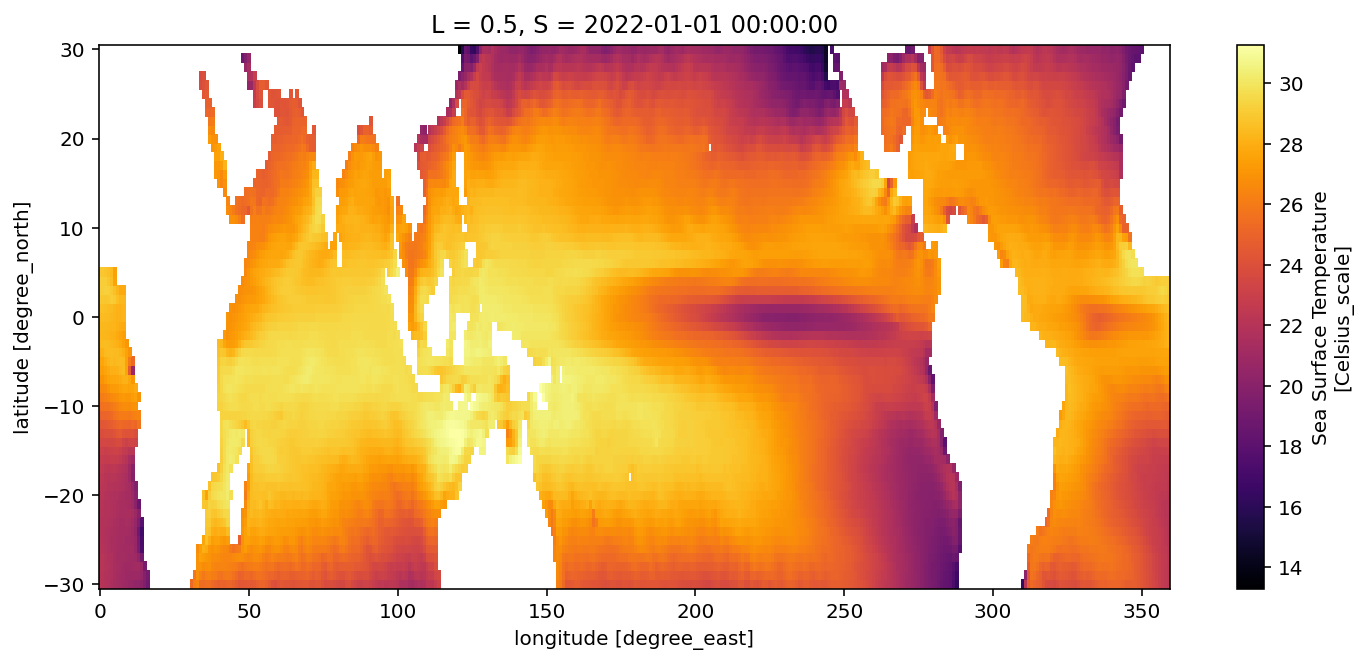

In [55]:

nasa.sst.plot(figsize=(12, 5), cmap='inferno');